In [2]:
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import numpy as np
import random
from random import shuffle
from random import randint

import pickle
import cv2
import glob
import time
print('libaries imported')

libaries imported


In [3]:
#Import Images to train the Classifier on
##The provided image dataset from the repository is rather small with a size of 150mb
##This is easy on the today's RAM so they are all loaded at once.


print('loading data',end='')
cars = []
for img in glob.glob("M:/udacityND/P5/training_data/vehicles/GTI_Far/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    ##double the dataset by mirroring vertically
    cars.append(np.fliplr(image))
print('.',end='')
for img in glob.glob("M:/udacityND/P5/training_data/vehicles/GTI_Left/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    cars.append(np.fliplr(image))
print('.',end='')
for img in glob.glob("M:/udacityND/P5/training_data/vehicles/GTI_MiddleClose/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    cars.append(np.fliplr(image))
print('.',end='')
for img in glob.glob("M:/udacityND/P5/training_data/vehicles/GTI_Right/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    cars.append(np.fliplr(image))
print('.',end='')
for img in glob.glob("M:/udacityND/P5/training_data/vehicles/KITTI_extracted/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cars.append(image)
    cars.append(np.fliplr(image))
print('.',end='')
    
notcars=[]
for img in glob.glob("M:/udacityND/P5/training_data/non-vehicles/GTI/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars.append(image)
    notcars.append(np.fliplr(image))
print('.',end='')
for img in glob.glob("M:/udacityND/P5/training_data/non-vehicles/Extras/*.png"):
    image= cv2.imread(img)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    notcars.append(image) 
    notcars.append(np.fliplr(image))
print('.',end='') 

#Shuffle the imaga data as it is sorted by timestamp
random.shuffle(cars)
random.shuffle(notcars)

#cars should contain now 8792 images, and notcars 8968, if not there was an error
if (len(cars)==8792*2) & (len(notcars)==8968*2):
    print('loading complete')
elif len(cars)==8792*2:
    print('ERROR while loading non-vehicles')
else:
    print('ERROR while loading vehicles')


loading data.......loading complete


### Explore the Dataset
The images have a resolution of 64x64 and are RGB. In total there are 8792 images of cars and 8968 images that feature no cars in their content. Below are some example images

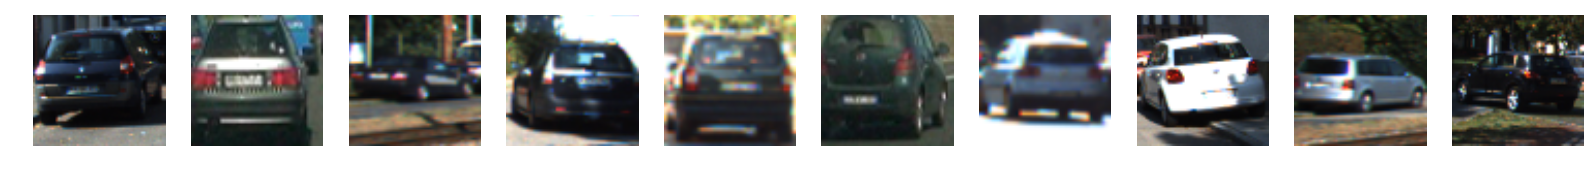

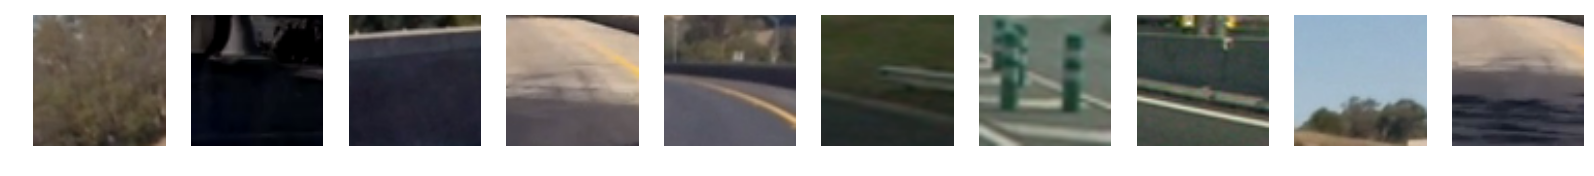

In [4]:
for i in range(10):
    plt.figure(1,figsize=(20, 8))
    plt.subplot(1,10,i+1) ; plt.imshow(cars[randint(0,len(cars))]); plt.axis('off')    
plt.show()
for i in range(10):
    plt.figure(2,figsize=(20, 8))
    plt.subplot(1,10,i+1) ; plt.imshow(notcars[randint(0,len(notcars))]); plt.axis('off')    
plt.show()

# (HOG) Histogram of oriented Gradients
A function is implemented to compute the HoG values for an image and to call it to extract the HoG features from a list of images. Later its' parametrization is evaluated.

In [5]:
##################(c) lesson 29
## HOG Features ##
##################
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in range(len(imgs)):
        # Read in each one by one
        image = imgs[file]
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


def extract_features_from_windows(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    # Read in each one by one
    image = imgs
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
    # Return list of feature vectors
    return features

## Linear Support Vector Classification and its' Training
Use the functions above to extract HoG features from images and normalize the values. The dataset is going to be labeled, shuffled and split into training and test set. Then train a classifier with a small batch of these processed and labeled images to evaluate good settings for the given task to detect cars. 

In [6]:
#############################(c) lesson 29
## linear SVC and Training ##
#############################
# Batch Set
batch_size = 10
cars_batch = cars#[0:batch_size]
notcars_batch = notcars#[0:batch_size]

# Parametrization of HoG function
colorspace = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient =12         # up to 9 is considered reasonable
pix_per_cell = 10
cell_per_block = 2
hog_channel = 'ALL'   #  0, 1, 2, or "ALL"

# compute HoG features
t1=time.time()
car_features = extract_features(cars_batch, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars_batch, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
# merge feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# THE FEATURES ARE NOT GOING TO BE SCALED
# this is only usefull when more than one featuregenerator is used, but here is only HOG
X_scaler = StandardScaler().fit(X)
scaled_X=X



# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.15, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

##Linear Support Vector Classification
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

89.11 Seconds to extract HOG features...
Using: 10 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 1920
18.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  1.  0.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  1.  1.  1.  0.]
0.40002 Seconds to predict 10 labels with SVC


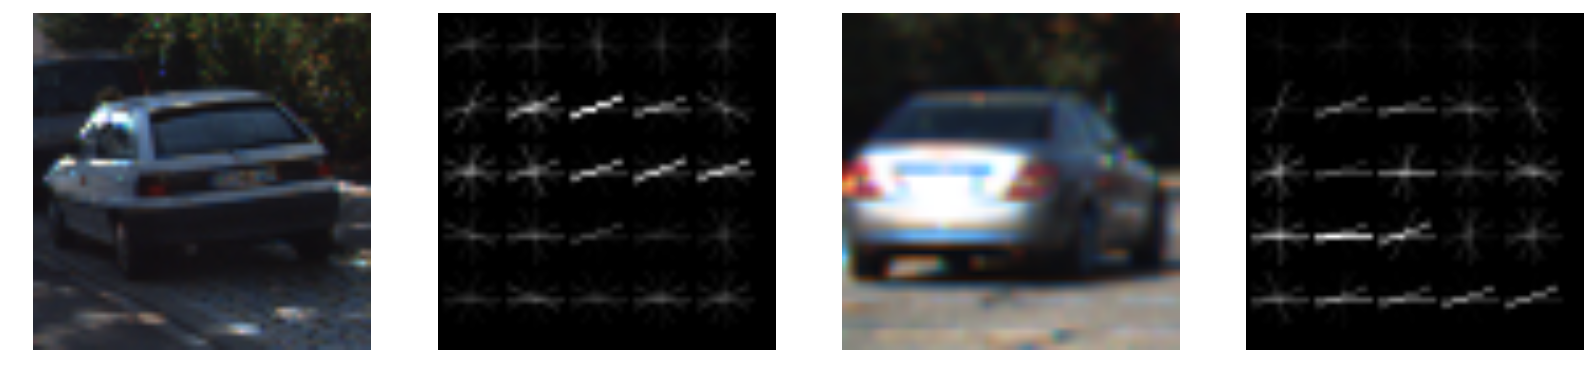

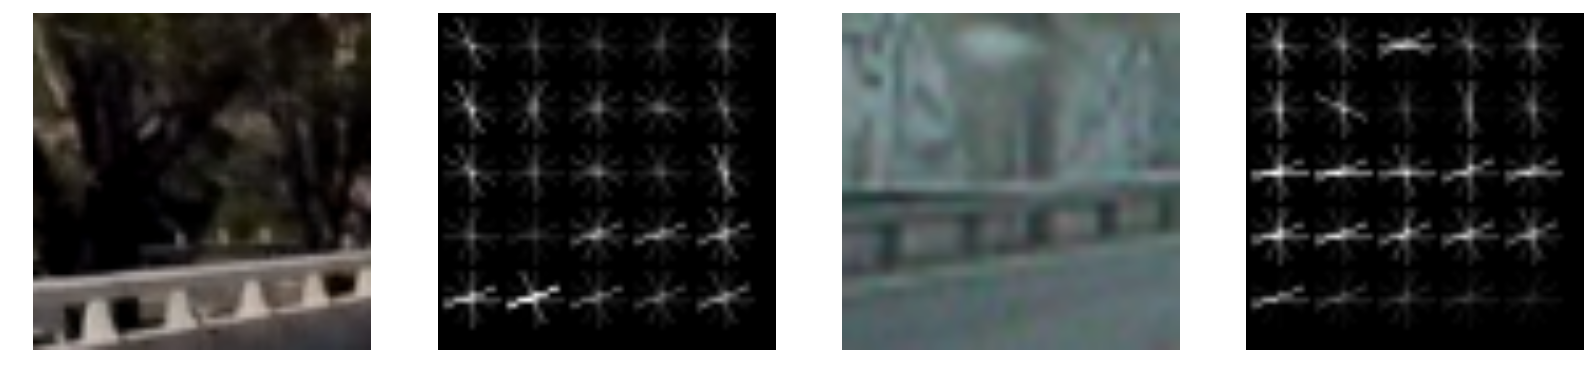

In [7]:
#Visualize this particular parametrization
for i in range(2):
    img=cars[randint(0,len(cars))]
    plt.figure(1,figsize=(20, 8))
    plt.subplot(1,4,i*2+1) ; plt.imshow(img); plt.axis('off')
    feat, img=get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    plt.subplot(1,4,i*2+2) ; plt.imshow(img,cmap='gray'); plt.axis('off') 
plt.show()
for i in range(2):
    img=notcars[randint(0,len(notcars))]
    plt.figure(1,figsize=(20, 8))
    plt.subplot(1,4,i*2+1) ; plt.imshow(img); plt.axis('off')
    feat, img=get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
    plt.subplot(1,4,i*2+2) ; plt.imshow(img,cmap='gray'); plt.axis('off')   
plt.show()

## Sliding Window Pipeline

Now that a good parametrization is found and the classifier is trained on the provided dataset, it is time to build a pipeline to detect cars within an image. The suggested method of sliding windows is implemented. There will be an area of ineterest defined and first the large windows do the search and at last the smallest windowsizes. Also the search pattern of the smaller windows is randomized. If it is implemented as a realtime check, this serves the possibilty to interrupt the search after a defined time and still have checked the critical areas and also to have a chance to search at least some of the areas that have not yet been searched. For a interrupt to be possible within the for-loop of the function "search_windows" has to be a breakstatement be formulated, which is not done at this point, as realtime-capability is not taken in consideration.

In [8]:
from scipy.ndimage.measurements import label

#####################(c) lesson 34
## Sliding Windows ##
#####################
# Define a function that takes an image, start and sto72p positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows_l, windows_m, windows_s, clf, scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list

    for i in range(3):
        if i==0:
            windows=windows_l
        elif i==1:
            windows=windows_m
        else:
            windows=windows_s

        for window in windows:
            #3) Extract the test window from original image and resize as the trainingdata for the classifier
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
            #4) Extract features for that window using single_img_features()
            features = extract_features_from_windows(test_img, cspace,  
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
            #5) Scale extracted features to be fed to classifier
            #X = features.astype(np.float64) 
            #scaler = StandardScaler().fit(X)
            # normalize the feature vector X
            #test_features = scaler.transform(X)
            #NO SCALING IF FEATURES
            test_features = features #scaler.transform(np.array(features).reshape(1, -1))

            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

################(c) lesson 5
## Draw Boxes ##
################
# Draw a rectangle based upon upper left corner and bottom right corner defined by an inpu tuple
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img
#===================================================================================#
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [18]:
import collections
heatmap     = collections.deque(maxlen=10) #https://discussions.udacity.com/t/how-to-take-average-heatmaps/242409/5?u=christoph.reiners
heatmap_sum = collections.deque(maxlen=10)
def detect_vehicles_video(image,svc=svc, X_scaler=X_scaler, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block, hog_channel=hog_channel):

    windows_l = slide_window(image, x_start_stop=[int(1280*0.45), None], y_start_stop=[int(720*0.5), None], 
                        xy_window=(130, 130), xy_overlap=(0.55, 0.75))
    windows_m = slide_window(image, x_start_stop=[int(1280*0.45), None], y_start_stop=[int(720*0.5), int(720*0.95)], 
                        xy_window=(95, 95), xy_overlap=(0.55, 0.75))
    windows_s = slide_window(image, x_start_stop=[int(1280*0.45), int(1280*0.85)], y_start_stop=[int(720*0.45), int(720*0.6)], 
                        xy_window=(30, 30), xy_overlap=(0.5, 0.75))
    random.shuffle(windows_s)


    hot_windows = search_windows(image, windows_l, windows_m, windows_s, svc, X_scaler,
                                 cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, hog_channel=hog_channel)

    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
    #plt.imshow(window_img)
    #plt.show()

    heatmap_cur = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_cur = add_heat(heatmap_cur, hot_windows)
    #plt.imshow(heatmap)
    #plt.show()

    heatmap.append(heatmap_cur)
    #heatmap_avg = np.mean(heatmap, axis=1)
    #heatmap_avg=apply_threshold(heatmap_avg,2)
    heatmap_s = sum(heatmap)
    heatmap_s=apply_threshold(heatmap_s,18)
    heatmap_sum.append(heatmap_s)
    heatmap_avg = np.mean(heatmap_sum, axis=0)
    heatmap_avg=apply_threshold(heatmap_avg,14)
    
    #plt.imshow(heatmap)
    #plt.show()

    labels = label(heatmap_avg)
    labels=draw_labeled_bboxes(image, labels)
    #plt.imshow(labels)
    #plt.show()
    
    return labels


In [ ]:
##############
# initialize #
##############

heatmap     =[]
heatmap_sum =[]
label_smooth=[]
heatmap     = collections.deque(maxlen=25)
heatmap_sum = collections.deque(maxlen=25)
label_smooth = collections.deque(maxlen=15)

import moviepy
from moviepy.editor import VideoFileClip
########################
# start lane detection #
########################
video_input = VideoFileClip('M:/udacityND/P5/project_video.mp4')
video_output = 'M:/udacityND/P5/project_video_output_final.mp4'
processed_video = video_input.fl_image(detect_vehicles_video)
%time processed_video.write_videofile(video_output, audio=False)



---

# ONLY FOR TESTING AND EXTRACTING

---

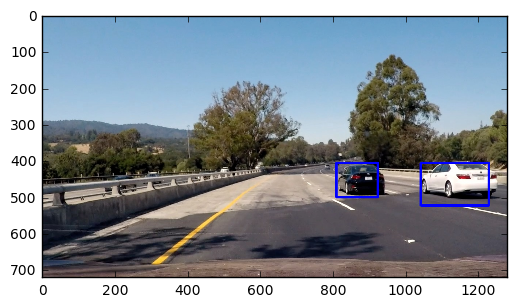

In [17]:


image = cv2.imread('M:/udacityND/P5/test_images/test4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detect=detect_vehicles_video(image,svc, X_scaler, colorspace, orient, pix_per_cell,cell_per_block, hog_channel)

plt.imshow(detect)
plt.show()


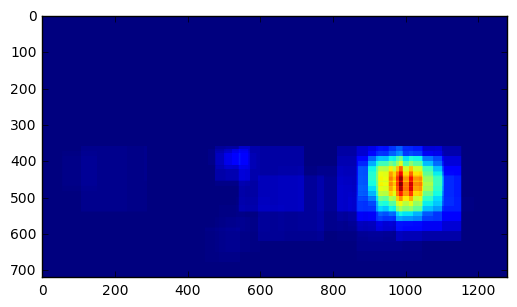

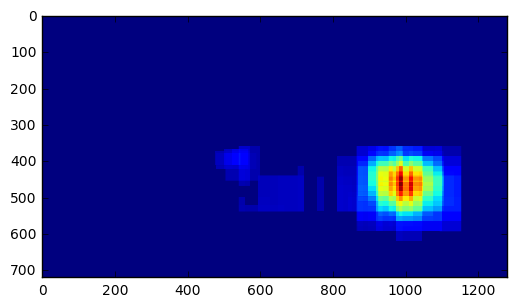

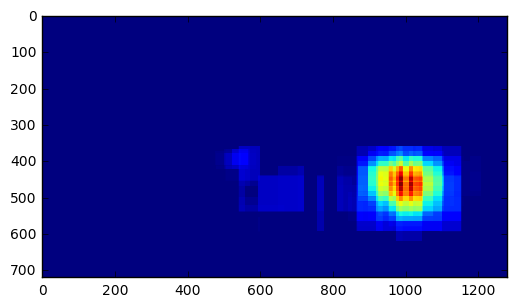

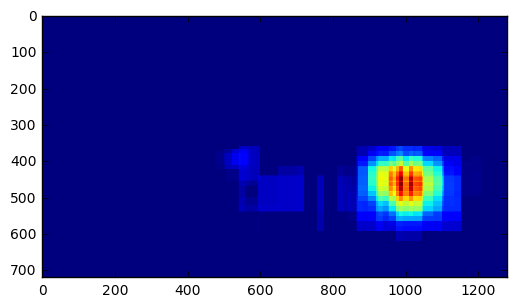

In [32]:
heatmap_s = sum(heatmap)
plt.imshow(heatmap_s)
plt.show()

heatmap_s=apply_threshold(heatmap_s,10)
plt.imshow(heatmap_s)
plt.show()

heatmap_avg = np.mean(heatmap_sum, axis=0)
plt.imshow(heatmap_avg)
plt.show()
heatmap_avg=apply_threshold(heatmap_avg,2)

plt.imshow(heatmap_avg)
plt.show()

(720, 1280)


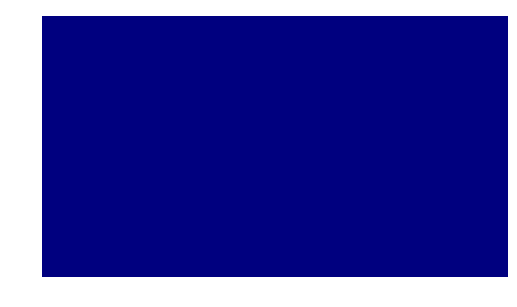

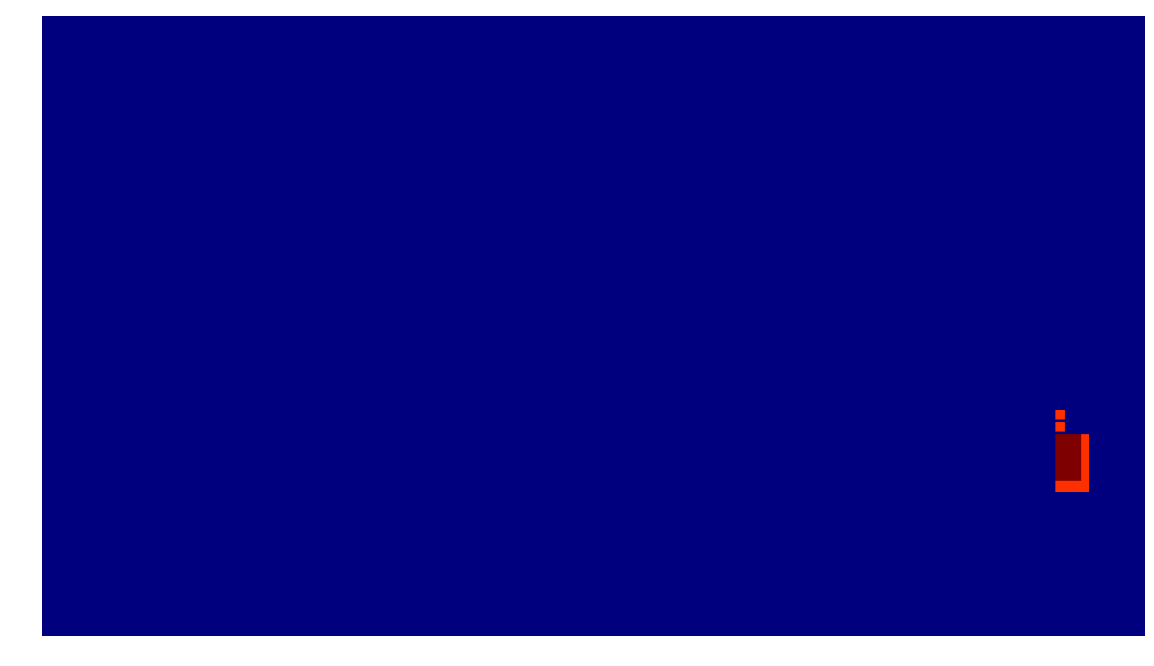

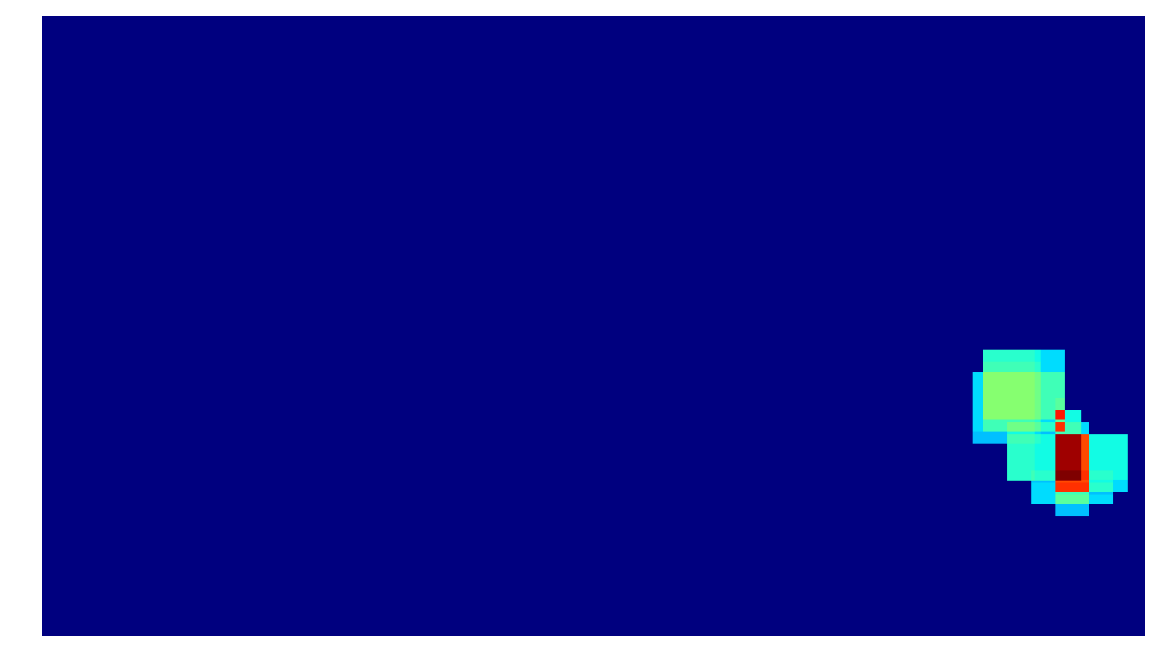

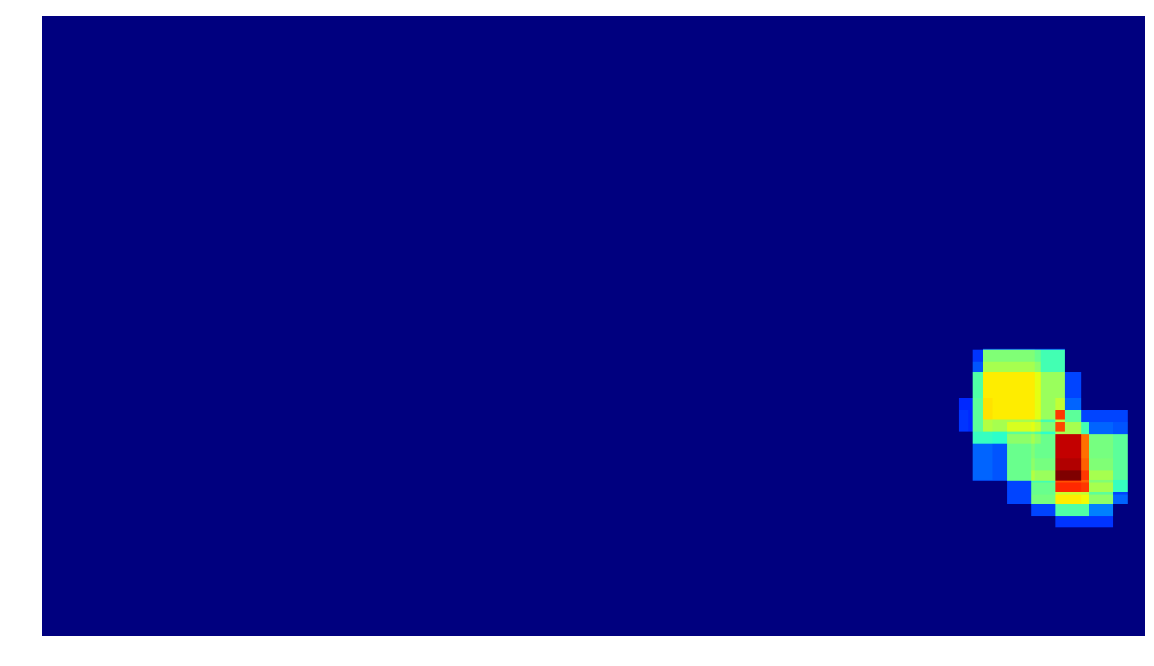

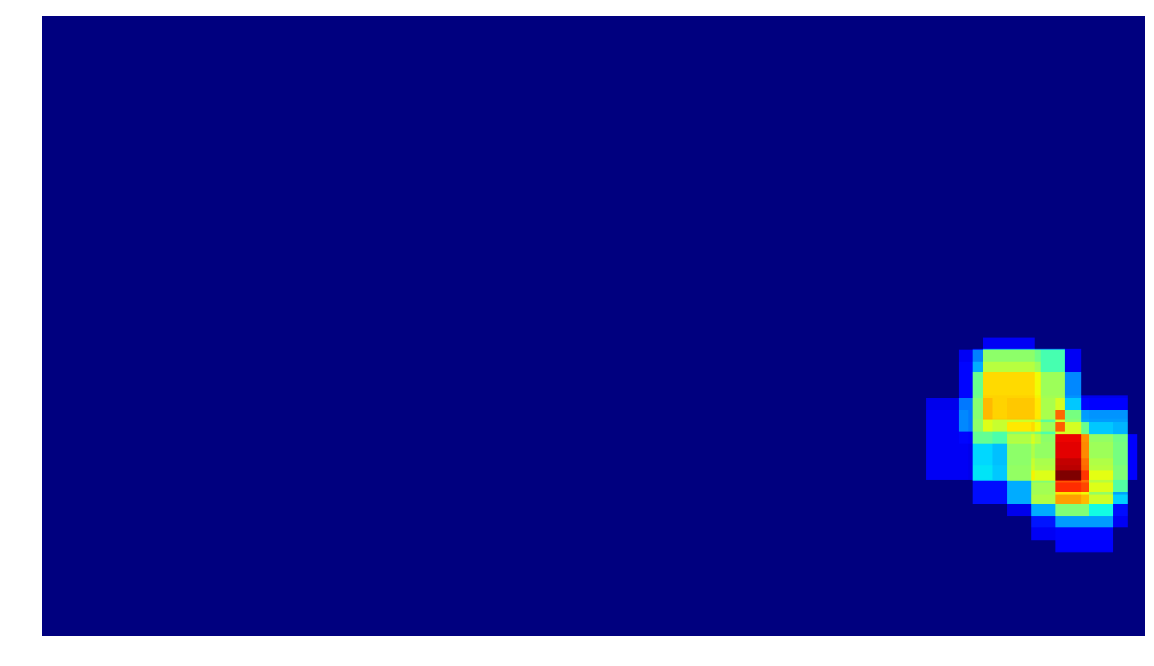

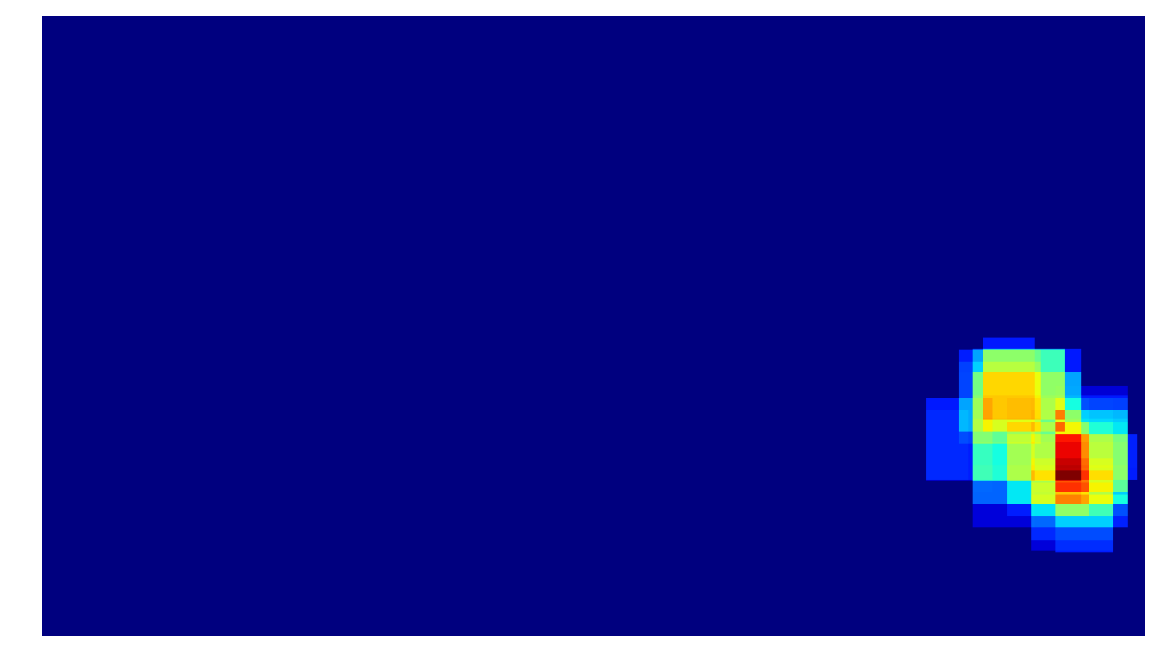

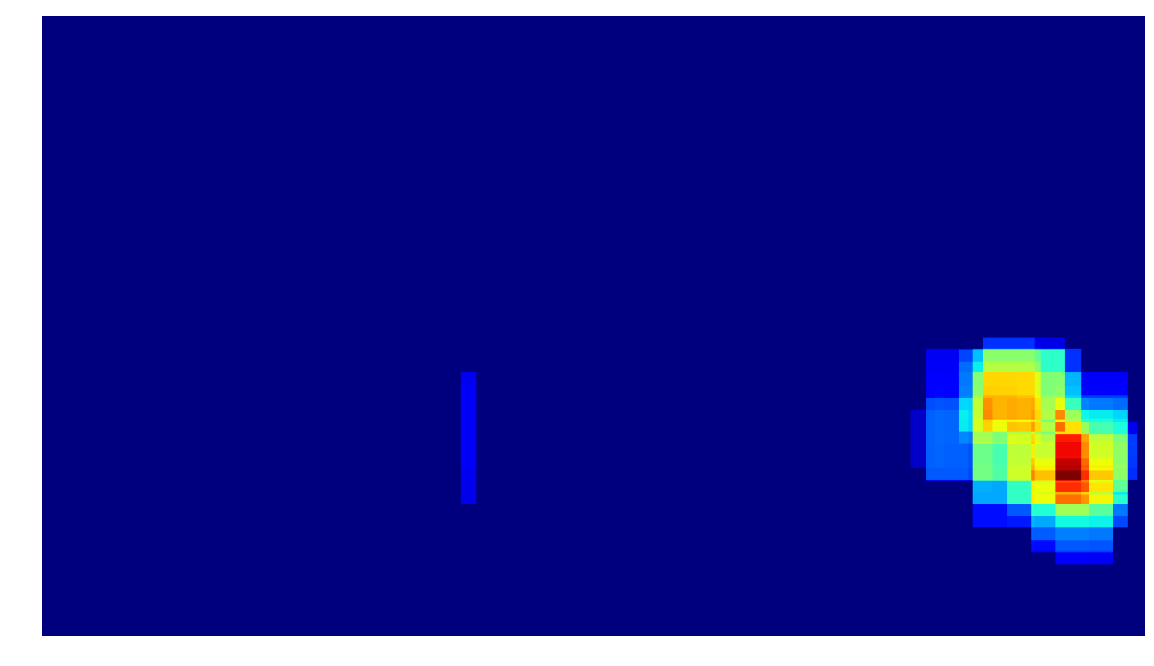

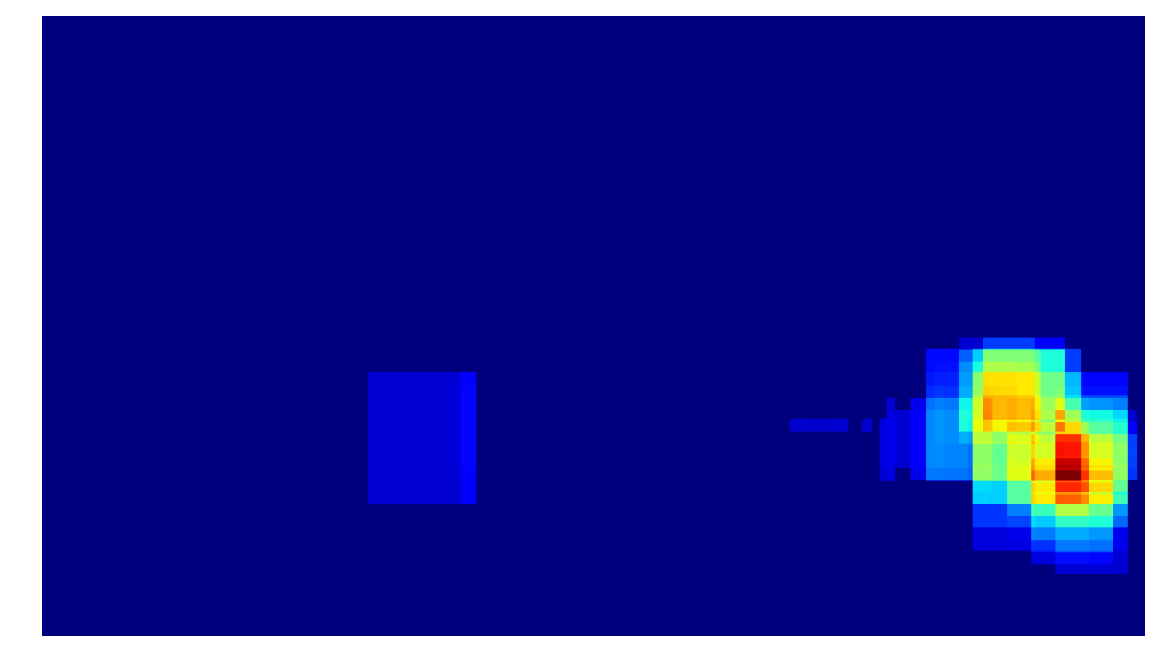

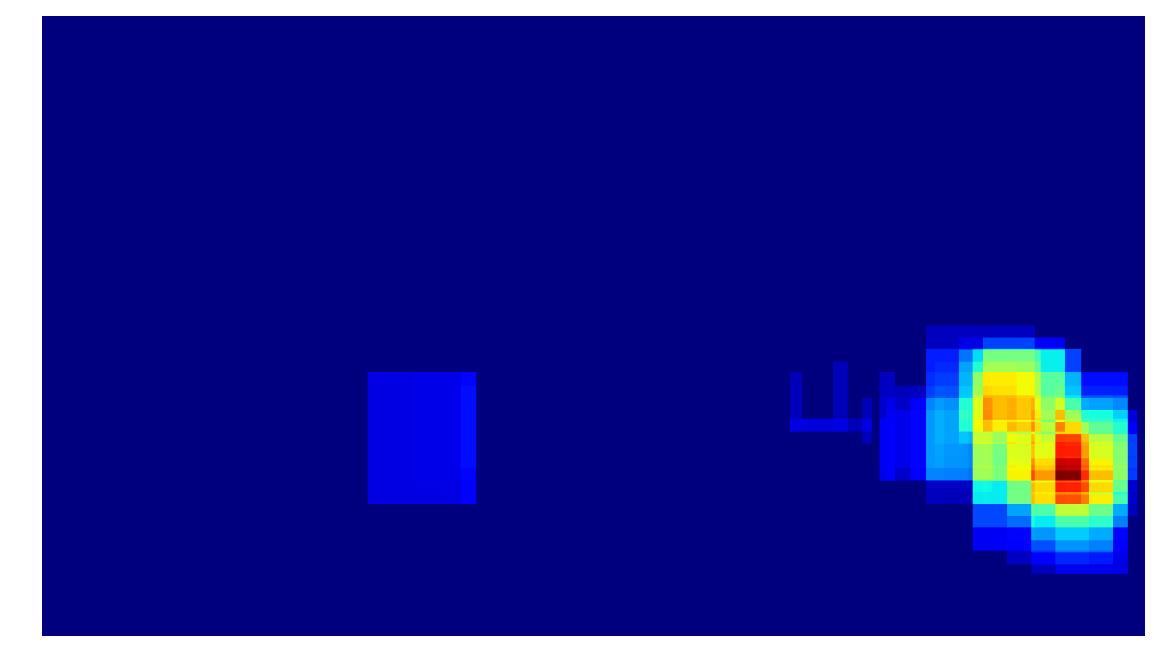

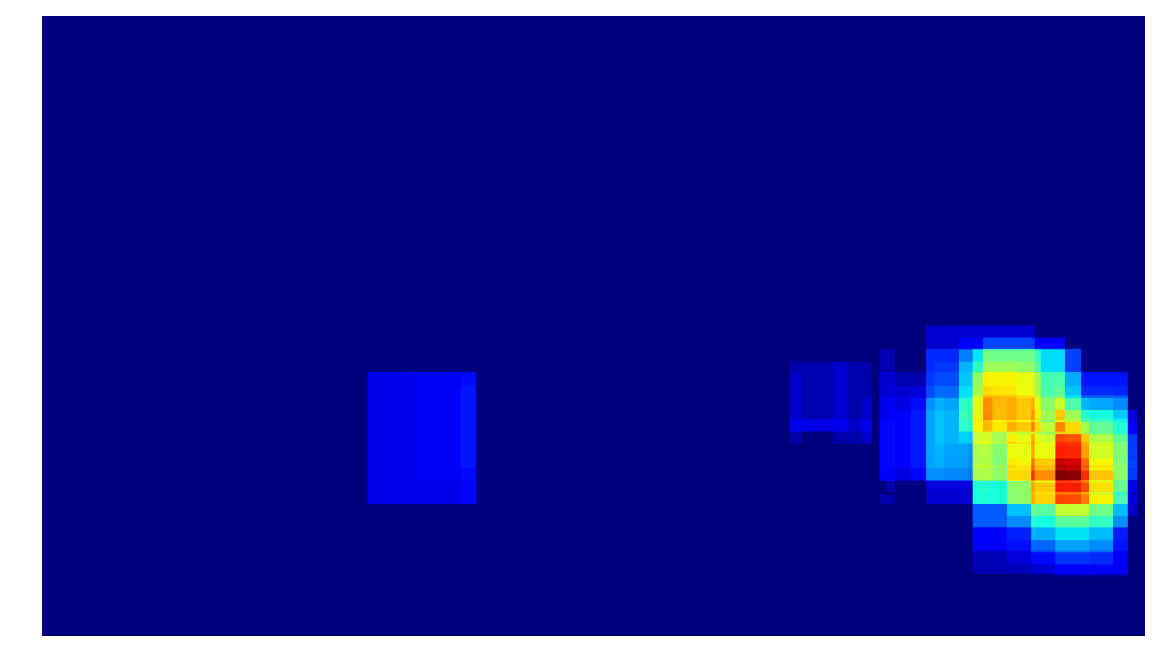

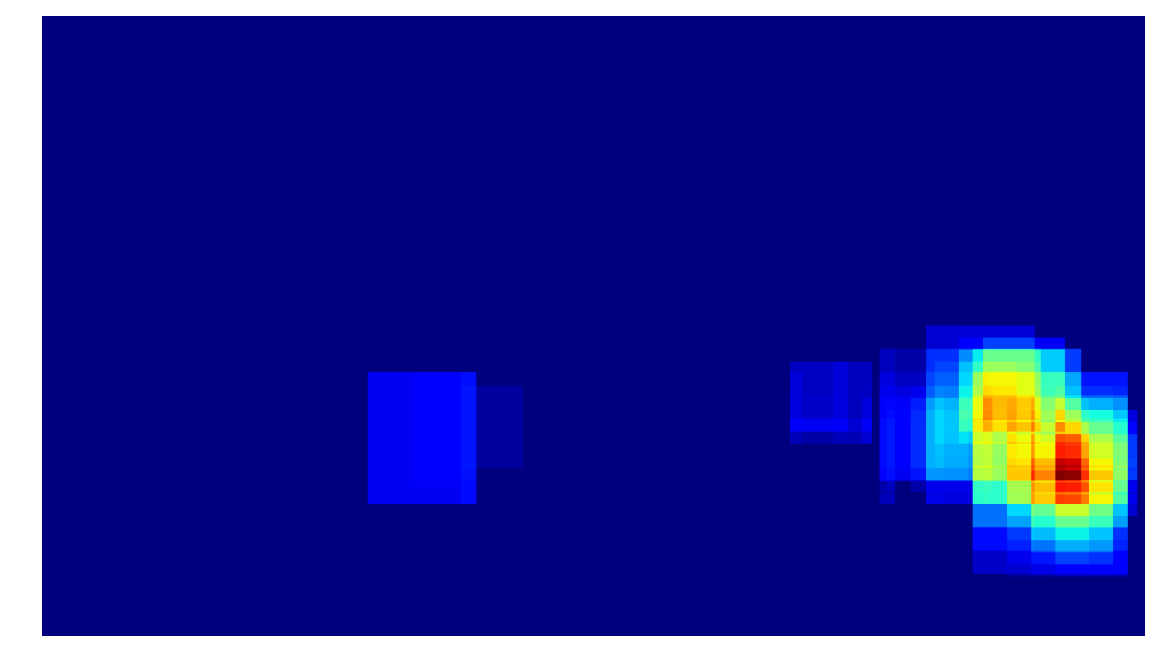

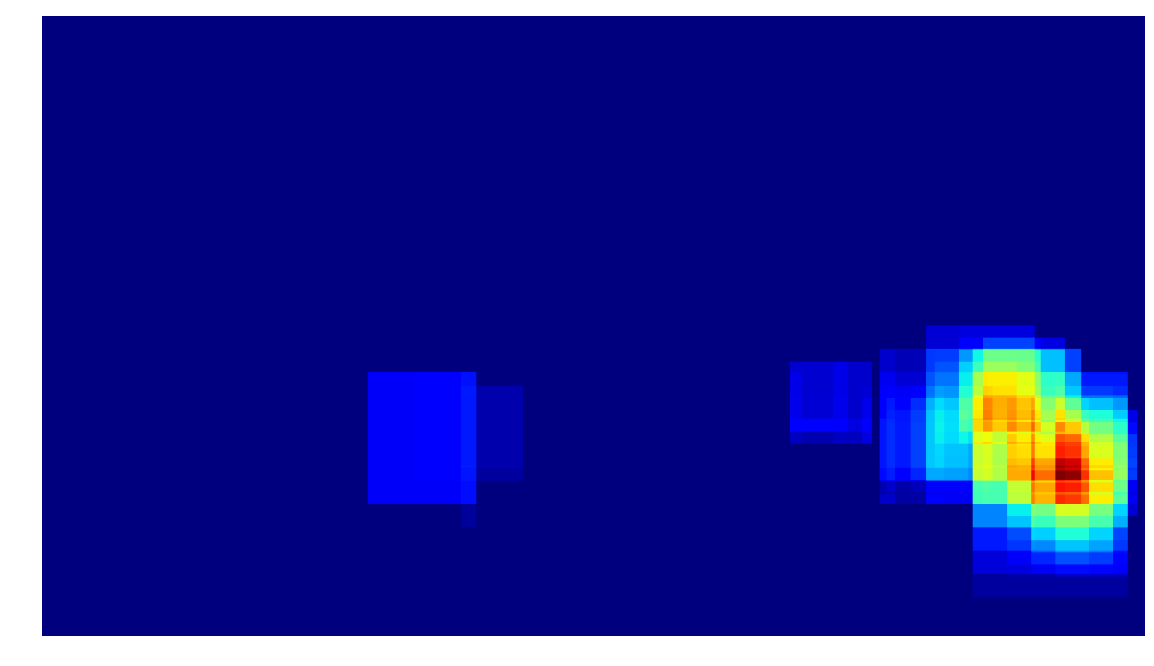

In [47]:
old setting youtube

  windows_l = slide_window(image, x_start_stop=[int(1280*0.45), None], y_start_stop=[int(720*0.5), None], 
                        xy_window=(130, 130), xy_overlap=(0.55, 0.75))
    windows_m = slide_window(image, x_start_stop=[int(1280*0.45), None], y_start_stop=[int(720*0.5), int(720*0.95)], 
                        xy_window=(95, 95), xy_overlap=(0.55, 0.75))
    windows_s = slide_window(image, x_start_stop=[int(1280*0.45), int(1280*0.85)], y_start_stop=[int(720*0.45), int(720*0.6)], 
                        xy_window=(30, 30), xy_overlap=(0.5, 0.75))
    random.shuffle(windows_s)


    hot_windows = search_windows(image, windows_l, windows_m, windows_s, svc, X_scaler,
                                 cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, hog_channel=hog_channel)

    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    
    #plt.imshow(window_img)
    #plt.show()

    heatmap_cur = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap_cur = add_heat(heatmap_cur, hot_windows)
    #plt.imshow(heatmap)
    #plt.show()

    heatmap.append(heatmap_cur)
    #heatmap_avg = np.mean(heatmap, axis=1)
    #heatmap_avg=apply_threshold(heatmap_avg,2)
    heatmap_s = sum(heatmap)
    heatmap_s=apply_threshold(heatmap_s,22)
    heatmap_sum.append(heatmap_s)
    heatmap_avg = np.mean(heatmap_sum, axis=0)
    heatmap_avg=apply_threshold(heatmap_avg,9)

train your classifier, then run your sliding window search, extract features, and predict whether each window contains a car or not

In [ ]:
#multiwindow search and classify(c) 34





# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, , cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, , cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [ ]:
#HOG subsampling window search 35


from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
#heat map 37

from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


Tip: To help with reducing false positives, other ideas you could have tried include:
Using the SVM's built-in decision_function method, which returns a confidence score based on how far a data point is from the decision boundary — higher values equate to higher confidence predictions that can be thresholded.
Augment the training with hard negative mining.
http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function16

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image=file
        img_features=single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
        features.append(img_features)
    # Return list of feature vectors
    return features